In [41]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


## Visualização de escoamento


### Mapa de calor
0 - azul

1 - vermelho

eixo x,y e z (plano)

### Mapa de resultados numeros com vetores de mesmo tamanho


### Resultados numeros com linhas de corrente
- linhas de corrente: linhas tangentes a velocidade (somatorio). linha de tangete a linha do vetor velocidade (trajetoria da particula do vetor da velocidade)

[ ] Implementação do programa e simulaçoes

[ ] Coleta e analise de dados

- Ajustar os aleatórios do RCE.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive

11ª Reunião (Remota)
- Verificar pendências
- Ajustar o RCE, seguindo passo a passo no chat do google.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão (verificar).
- Fazer backup da nova versão no drive
- Tipo, qtde e limite de variáveis de decisão são dados de entrada e impactam em ajuste da função individual do DEAP (isso será visto depois).
- Verificar se a explicação do resultado e os gráficos estão corretos.

## Classe Setup e DataExploration

In [42]:
class Setup:
    def __init__(self, params):
        self.params = params
        self.CXPB = params["CROSSOVER"]
        self.MUTPB = params["MUTACAO"]
        self.NGEN = params["NUM_GENERATIONS"]
        self.POP_SIZE = params["POP_SIZE"]
        self.IND_SIZE = params["IND_SIZE"]
        self.CROSSOVER, self.MUTACAO, self.NUM_GENERATIONS, self.POPULATION_SIZE = (
            self.CXPB,
            self.MUTPB,
            self.NGEN, 
            self.POP_SIZE,
        )
        self.SIZE_INDIVIDUAL = self.IND_SIZE
        self.evaluations = 0
        self.num_repopulation = int(self.NUM_GENERATIONS * 0.20)
        self.type = params["type"].lower()
        if self.type == "maximize":
            print("Método escolhido: Maximizar")
            creator.create("Fitness", base.Fitness, weights=(1.0,))
        else:
            print("Método escolhido: Minimizar")
            creator.create("Fitness", base.Fitness, weights=(-1.0,))

        # creator.create("Individual", list, fitness=creator.Fitness)

        self.dataset = {}
        self.beta_constants = {}


        #!Criando invidivuo
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create(
            "Individual", list, fitness=creator.FitnessMin, rce=str, index=int
        )
        self.toolbox = base.Toolbox()
        # todo gerando atributos ao ind
        self.toolbox.register(
            "attr_rce", random.uniform, 0.0, 9.9
        )  
        self.toolbox.register("attr_int", random.uniform, 1, 1000)

        self.toolbox.register("attribute", random.uniform, -5.12, 5.12)
        self.toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            self.toolbox.attribute,
            n=self.SIZE_INDIVIDUAL,
        )

        #paramentos evolutivos
        self.toolbox.register(
            "population", tools.initRepeat, list, self.toolbox.individual
        )
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate_fitness)

    def evaluate_fitness(self, individual):
        if self.type == "minimaze":
            result = minimize(self.rastrigin, x0=np.zeros(self.IND_SIZE), method="BFGS")
            fitness_value = result.fun
        return fitness_value

    def gerarDataset(self, excel):
        df = pd.read_excel(excel)
        print(df.columns)
        self.dataset = {
            "CXPB": self.CROSSOVER,
            "TAXA_MUTACAO": self.MUTACAO,
            "NUM_GEN": self.NUM_GENERATIONS,
            "POP_SIZE": self.POPULATION_SIZE,
            "IND_SIZE": self.SIZE_INDIVIDUAL,
            "evaluations": self.evaluations,
            "NUM_REPOPULATION": self.num_repopulation,
        }

    def rastrigin(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.SIZE_INDIVIDUAL
        for i in range(self.SIZE_INDIVIDUAL):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rastrigin_decisionVariables(self, individual, decision_variables):
        self.evaluations += 1
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rosenbrock(self, x):
        return np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def globalSolutions(self):
        n_dimensions = 2

        try:
            rastrigin_result = minimize(
                self.rastrigin, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            rosenbrock_result = minimize(
                self.rosenbrock, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)

        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)


class DataExploration:
    def __init__(self):
        self.fit_array = []

    def default_rastrigin(self,x, y):
        return 20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))


    def generateSimpleDataset(self):
        # Geração dos dados
        data = pd.DataFrame(
            {
                'x': np.linspace(-5, 5, 400),
                'y': np.linspace(-5, 5, 400)
            }

        )

        #display(data)

        # Generate meshgrid data
        x = np.linspace(-5.15, 5.15, 100)
        y = np.linspace(-5.15, 5.15, 100)
        X, Y = np.meshgrid(x, y)

        # Calculate function values
        #print(X.shape,Y.shape)

        return X,Y

    def plot_Rastrigin_2D(self,X, Y, Z_rastrigin,logbook ,best_variables =[] ):
        fig = plt.figure(figsize=(18, 10))
        ax1 = fig.add_subplot(231)
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)
        line1 = ax1.plot(generation, statics["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(generation, statics["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(generation, statics["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        ax1.set_title("GERAÇÃO X FITNESS")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")


        # Rastrigin 2D
        ax2 = fig.add_subplot(232)
        ax2.contourf(X, Y, Z_rastrigin, levels=50, cmap='viridis')
        #ax2.plot(best_variables, color='red',)
        for num in range(len(best_variables)):
            var_x = round(best_variables[num])
            var_y = best_variables[num]
            ax2.scatter(var_x,var_y, color = "pink",    marker="o" , label='best variables')
        ax2.set_title('Rastrigin Function 2D')
        ax2.set_xlabel("X")
        ax2.set_ylabel('Y')


        #Rastrigin 3D
        ax5 = fig.add_subplot(233, projection='3d')
        ax5.plot_surface(X, Y, Z_rastrigin, cmap='viridis', edgecolor='none')
        ax5.set_title('Rastrigin Function 3D')
        ax5.set_xlabel('X')
        ax5.set_ylabel('Y')
        ax5.set_zlabel('Z')

        plt.tight_layout()
        plt.show()


    def show_rastrigin_benchmark(self,logbook,best = []):
        X,Y = self.generateSimpleDataset()

        Z_3D_rastrigin = self.default_rastrigin(X,Y )

        self.plot_Rastrigin_2D(X, Y, Z_3D_rastrigin,logbook,best)    

    def statistics_per_generation_df(self, logbook):
        generations = logbook.select("gen")
        min_fitness = logbook.select("min")
        avg_fitness = logbook.select("avg")
        max_fitness = logbook.select("max")
        std_fitness = logbook.select("std")

        data = {
            "Generation": generations,
            "Min Fitness": min_fitness,
            "Average Fitness": avg_fitness,
            "Max Fitness": max_fitness,
            "Std Fitness": std_fitness,
        }

        df = pd.DataFrame(data)
        display(df)

    def plot_diversidade_genes(self, population):
        print("Plotando diversidade dos genes")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        x_values = [ind[0] for ind in population]  # Retorna a primeira posição do vetor
        y_values = [ind[1] for ind in population]  # Retorna a segunda posição do vetor

        ax.scatter(x_values, y_values, c="b", label="Population")
        ax.set_title("Diversity of genes")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
        plt.show()

    def plot_scatter_turbina(self, turbina, best_variables):
        # Plotar o gráfico de dispersão
        plt.figure(figsize=(10, 6))

        plt.scatter(
            turbina["Curva_Teórica(KWh)"],
            turbina["ActivePower(kW)"],
            label="Dados Reais",
            color="blue",
        )
        plt.plot(
            turbina["Curva_Teórica(KWh)"],
            best_variables * turbina["Curva_Teórica(KWh)"],
            label="Melhor Solução",
            color="red",
        )

        plt.xlabel("Potência Teórica (KWh)")
        plt.ylabel("Potência Ativa (kW)")
        plt.title("Comparação entre Potência Teórica e Potência Ativa")
        plt.legend()
        plt.grid(True)
        plt.show()

    def displayDataFrameInfo(self, array, text):
        # Criar DataFrame com as melhores soluções
        best_df = pd.DataFrame(array)
        self.cout(text)
        display(best_df)
        return best_df
    
    def show_conjuntoElite(self, pop):
        print("\n\n-->Conjunto Elite:", pop)
        best_df = pd.DataFrame(pop)
        display(best_df.sort_values(by = "Fitness" ,ascending=False))



    def calculate_stats(self, logbook):

        fit_avg = logbook.select("avg")
        fit_std = logbook.select("std")
        fit_min = logbook.select("min")
        fit_max = logbook.select("max")

        self.fit_array.append(fit_min)
        self.fit_array.append(fit_avg)
        self.fit_array.append(fit_max)
        self.fit_array.append(fit_std)

        return {
            "min_fitness": fit_min,
            "max_fitness": fit_max,
            "avg_fitness": fit_avg,
            "std_fitness": fit_std,
        }

    def rastrigin(self, x):
        A = 10
        return A * len(x) + sum(
            [(x[i] ** 2 - A * np.cos(2 * math.pi * x[i])) for i in range(len(x))]
        )

    def cout(self, msg):
        print("=================================================================")
        print(msg)
        print("=================================================================")

    def visualize(self, logbook, pop, problem_type="minimaze", repopulation=True):
        generation = logbook.select("gen")
        statics = self.calculate_stats(logbook)

        if problem_type == "maximize":
            # Se o problema for de maximização, inverter os valores de fitness para exibir corretamente o gráfico
            statics = {
                key: [-value for value in values] for key, values in statics.items()
            }

        if repopulation:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = pop[best_solution_index]
            best_solution_fitness = statics["min_fitness"][best_solution_index]
        else:
            best_solution_index = statics["min_fitness"].index(
                min(statics["min_fitness"])
            )
            best_solution_variables = logbook.select("min")
            best_solution_fitness = min(statics["min_fitness"])

        # Soluções do problema
        self.cout("Soluções do problema")
        print("\nBest solution index = ", best_solution_index)
        print("\nBest solution variables =\n", best_solution_variables)
        print("\nBest solution fitness = ", best_solution_fitness)

        try:
            # Encontrar o ótimo global da função Rastrigin usando os valores fornecidos.
            opt = minimize(
                self.rastrigin, best_solution_variables, method="Nelder-Mead", tol=1e-6
            )
            print("\nÓtimo global da função Rastrigin = ", opt.fun)
            print("\nSolução ótima global = ", opt.x)
            # Comparar as soluções obt
            print(
                "\nPorcentagem de proximidade da solução em relação ao ótimo global = ",
                (1 - (best_solution_fitness / opt.fun)) * 100,
                "%",
            )
            distancia_otimoglobal = abs
            print(
                f"\nDistância da solução em relação ao ótimo global = {distancia_otimoglobal}",
            )

            self.grafico_convergencia(generation, statics, repopulation)
            self.graficoBarrasFitnessGeneration(generation, statics, repopulation)
        except:
            print("Erro validation :(")

    def grafico_convergencia(self, gen, lista, repopulation=False):
        fig, ax1 = plt.subplots()
        if repopulation:
            ax1.set_title("Com Repopulação")
        else:
            ax1.set_title("Sem Repopulação")

        

        line1 = ax1.plot(gen, lista["min_fitness"], "*b-", label="Minimum Fitness")
        line2 = ax1.plot(gen, lista["avg_fitness"], "+r-", label="Average Fitness")
        line3 = ax1.plot(gen, lista["max_fitness"], "og-", label="Maximum Fitness")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        lns = line1 + line2 + line3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc="upper right")

    def plot_grafico_barras(self, x, y):
        fig, ax = plt.subplots()
        ax.bar(x, y, color="b")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Fitness por Geração")
        plt.show()

    def graficoBarrasFitnessGeneration(self, generation, lista, repopulation=False):
        fig, ax = plt.subplots()
        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        if len(generation) > 1:
            best_solutions = [min(lista["min_fitness"]) for i in range(len(generation))]
            avg_fitness = lista["avg_fitness"]
            generations = np.arange(1, len(generation) + 1)

            ax.plot(
                generations,
                avg_fitness,
                marker="o",
                color="r",
                linestyle="--",
                label="Média Fitness por Geração",
            )
            ax.bar(generations, lista["min_fitness"], color="green", label="Melhor Fitness por Geração",  )

            ax.set_xlabel("Geração")
            ax.set_ylabel("Fitness")
            ax.set_title("Melhor Fitness e Média por Geração")
            ax.legend()
            plt.show()


    def plot_diversidade(self, population, repopulation=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if repopulation:
            ax.set_title("Com Repopulação")
        else:
            ax.set_title("Sem Repopulação")

        x_values = [ind[0] for ind in population]
        y_values = [ind[1] for ind in population]
        z_values = [ind[2] for ind in population]

        ax.scatter(x_values, y_values, z_values, c="b", label="Population")

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()
        ax.grid(True)

        plt.show()

## Algoritimo Evolutivo RCE

In [43]:
class AlgoritimoEvolutivoRCE:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)

        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.POPULATION = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.pop_RCE = []
        self.hof.update(self.POPULATION)

        self.best_solutions_array = []
        self.best_individual_array = []
        self.fitness_array = []
        self.CONJUNTO_ELITE_ARRAY = []
        self.allIndividualValuesArray = []
        self.data = {}
        self.repopulation_counter = 0
        self.allFitnessValues = {}
        self.validateCounter = 0
        self.CONJUNTO_ELITE_RCE = set()

    def pesquisarLinear(self,array,num,pos=0):
        while ((pos < len(array)) and (array[pos] != num)):
            pos += 1

        if array[pos] == num:
            print("Valor encontrado")

    def registrarDados(self,generation):

        # Registrar estatísticas e melhores soluções
        for ind in self.POPULATION:
            avg_fitness_per_generation = np.mean(ind.fitness.values)
            std_deviation = np.std(ind.fitness.values)

        #! PEgandos os dados e colocando no df
        self.data = {
            "Generations": generation + 2,
            "Variaveis de Decisão": self.hof[0],
            "Evaluations": self.setup.evaluations,
            "Ind Valido":self.hof[0].fitness.valid,
            "Best Fitness": self.hof[0].fitness.values,
            "Media": avg_fitness_per_generation,
            "Desvio Padrao": std_deviation,
        }

        self.best_individual_array.append(self.data)

        self.visualizarPopAtual(
            generation, [avg_fitness_per_generation, std_deviation]
        )

    def generateInfoIndividual(self, new_pop, generation):
        ind_array = []

        for i, ind in enumerate(new_pop):
            ind.index = i

            ind_info = {
                "Generations": generation,
                "index": ind.index,
                "Variaveis de Decisão": ind,
                "Fitness": ind.fitness.values,
                "RCE": ind.rce,
            }

            # print(f"Index[{ind.index}] - ind_variables {ind} \n Fitness = {ind.fitness.values} ")
            ind_array.append(ind_info)

        return ind_array

    def show_ind_df(self, array, text):
        df = pd.DataFrame(array)
        print(text)
        display(df.head(40))

    def aplicar_RCE(self, generation):

        #! a - Cria uma pop aleatória (eliminando a pop aleatória criada na execução anterior do RCE)
        new_pop = self.setup.toolbox.population(n=self.setup.POP_SIZE) # retorna uma lista de individuos de var de decisao
        self.avaliarFitnessIndividuos(self.POPULATION)
        for ind in new_pop:
            if not ind.fitness.valid:
                fitness_value = self.setup.toolbox.evaluate(ind)
                ind.fitness.values = (fitness_value,)

        #! b - Coloca o elite hof da pop anterior  no topo (0)
        pop = self.elitismoSimples(self.POPULATION)
        print(f"Elitismo HOF Index[{pop[0].index}] {pop[0]} \n Fitness = {pop[0].fitness.values}") # pop[0] é o melhor individuo HOF
        new_pop[0] = self.setup.toolbox.clone(pop[0])

        #! c - Faz critério 1 e obtem os N melhores
        def criterio1():
            self.cout(f"CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração")
            elite_size = int(0.3 * len(self.POPULATION))

            sorted_population = sorted(
                new_pop, key=lambda x: x.fitness.values[0]
            )  # pop atual nao aleatoria

            # Selecionar os 30% primeiros indivíduos (os de menor fitness)
            elite_individuals = sorted_population[:elite_size]

            # Clonar os indivíduos selecionados para a nova população aleatória e marcar como RCE
            for i, ind in enumerate(elite_individuals, start=0):
                new_pop[i] = self.setup.toolbox.clone(ind)             
                new_pop[i].rce = "SIM_1"

            return elite_individuals

        ind_selecionados = criterio1()

        ind_array = self.generateInfoIndividual(new_pop, generation)
        self.show_ind_df(ind_array, "Individuos da nova população aleatória")

        #!d - Executa o critério 2 usando este array e vai colocando os indivíduos selecionados pelo critério 2 na pop aleatória (passo a)
        for ind in ind_selecionados:
            # print(f"Index[{ind.index}] - ind_variables {ind} \n Fitness = {ind.fitness.values} ")
            pass

            # todo criterio 2 nao funciona com os selecionados sendo clones

        ind_diferentes_var = self.criterio2(ind_selecionados) #critério2_diversidade(ind_array)

        
        # preenche a pop com os selecionados do criterio 2
        for i, ind in enumerate(ind_diferentes_var, start=0):
            new_pop[i] = self.setup.toolbox.clone(ind)
            new_pop[i].rce = "SIM_2"


        # TODO e - Criterio 3 retorna pop aleatória modificada (com hof + rce + Aleatorio)
        # new_pop_rce[0] = self.setup.toolbox.clone(pop[0])
        for ind in new_pop:
            if not ind.fitness.valid:
                fitness_value = self.setup.toolbox.evaluate(ind)
                ind.fitness.values = (fitness_value,)

        print("\nPopulação aleatória modificada após critério 3", new_pop)
        conjunto_elite = self.generateInfoIndividual(new_pop, generation)
        self.show_ind_df(conjunto_elite, "Individuos da nova população aleatória")

        new_population = new_pop
        return new_population

    def elitismoSimples(self,pop):
        self.hof.update(pop)
        pop[0] = self.setup.toolbox.clone(self.hof[0])
        return pop

    def criterio2(self, elite_individuals, delta=9):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'."""
        self.cout("CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.")
        self.pop_RCE = []

        for i in range(len(elite_individuals)):
            current_individual = elite_individuals[i]
            is_diferente = False

            for j in range(i + 1, len(elite_individuals)):
                other_individual = elite_individuals[j]
                diff_counter = 0

                for var_index in range(len(current_individual)):
                    current_var = current_individual[var_index]
                    other_var = other_individual[var_index]

                    if abs(current_var - other_var) > delta:
                        # print(abs(current_var - other_var))
                        diff_counter += 1

                if diff_counter >= 1:
                    is_diferente = True

            if is_diferente:
                self.pop_RCE.append(current_individual)
                print(f"Indivíduo VAR({current_individual}) diferente adicionado à nova população.")

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios.")

        print("tamanho elite",len(self.pop_RCE))
        return self.pop_RCE

    def criterio2_diversidade(self, elite_individuals, delta=5):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes."""
        new_pop1 = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.cout("CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes.")
        is_diferente = False

        for i in range(len(elite_individuals)):
            self.pop_RCE = []
            current_individual = elite_individuals[i]
            # print("\n---> Indivíduo atual:", current_individual["index"])

            if current_individual["RCE"] == "SIM":

                for j in range(i + 1, len(elite_individuals)):
                    other_individual = elite_individuals[j]
                    diff_counter = 0

                    for var_index in range(len(current_individual["Variaveis de Decisão"])):
                        current_var = current_individual["Variaveis de Decisão"][var_index]
                        other_var = other_individual["Variaveis de Decisão"][var_index]
                        # print("\ncalculando...")
                        # print(f"{current_var}x{other_var}")

                        if abs(current_var - other_var) > delta:
                            # print(abs(current_var - other_var))
                            diff_counter += 1

                        if diff_counter >= 1:
                            is_diferente = True
                            break

                    if is_diferente and current_individual["index"] not in self.pop_RCE:
                        self.pop_RCE.append(current_individual)
                        elite_size = len(elite_individuals)

                        for index in range(elite_size):
                            new_pop1[index] = self.setup.toolbox.clone(
                                current_individual["Variaveis de Decisão"]
                            )

                # print(f"Indivíduo Index({current_individual['index']}) diferente adicionado à nova população.")

        if not self.pop_RCE:
            print("Nenhum indivíduo atende aos critérios.")

        return new_pop1

    def avaliarFitnessIndividuos(self,pop):
        """Avaliar o fitness dos indivíduos da população atual."""
        fitnesses = map(self.setup.toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            if ind.fitness.values:
                ind.fitness.values = [fit]

    def checkDecisionVariablesAndFitnessFunction(self,decision_variables,fitness_function):

        # Verificar se as variáveis de decisão e a função de fitness foram fornecidas
        if decision_variables is None and fitness_function is None:
            # Gerar variáveis de decisão aleatórias para os indivíduos
            decision_variables = [
                random.random() for _ in range(self.setup.SIZE_INDIVIDUAL)
            ]

            # Definir a função de fitness padrão como a função Rastrigin
            fitness_function = self.setup.rastrigin_decisionVariables

        if decision_variables is None or fitness_function is None:
            if not hasattr(self, "decision_variables") or not hasattr(
                self, "fitness_function"
            ):
                raise ValueError(
                    "Variáveis de decisão e função de fitness não definidas. Use set_decision_variables_and_fitness_function primeiro."
                )
        else:
            self.decision_variables = decision_variables
            self.fitness_function = fitness_function

            # Definir a função de fitness com base na função fornecida
            def fitness_func(individual):
                return self.fitness_function(individual, self.decision_variables)

            # Registrar a função de fitness no toolbox
            self.setup.toolbox.register("evaluate", fitness_func)

    #! Main LOOP
    def run(self, RCE=False, decision_variables=None, fitness_function=None):
        # Avaliar o fitness da população inicial
        self.avaliarFitnessIndividuos(self.POPULATION)

        # Selecionando as variaveis de decisao e afuncao objeti
        self.checkDecisionVariablesAndFitnessFunction(decision_variables,fitness_function)    

        #! Loop principal através das gerações
        for current_generation in range(self.setup.NGEN):

            # Selecionar os indivíduos para reprodução
            offspring = self.setup.toolbox.select(self.POPULATION, k=len(self.POPULATION))

            # Clone the selected individuals
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            # Aplicar crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Aplicar mutação
            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            #  Avaliar o fitness dos novos indivíduos
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = [fit]

            #! Aplicar RCE
            if RCE and (
                 (current_generation + 1) % self.setup.num_repopulation == 0
            ):
                self.cout(
                    f"RCE being applied!  - Generation = {current_generation + 1} ",
                )
                #! f - copia pop aleatória modificada retornada para pop atual
                new_population = self.aplicar_RCE(current_generation + 1)
                print("\nPopulação gerada pelo RCE\n", new_population)
                self.POPULATION[:] = new_population
            else:
                self.POPULATION[:] = offspring

            # Registrar estatísticas no logbook
            self.elitismoSimples(self.POPULATION)
            self.registrarDados(current_generation)
            record = self.stats.compile(self.POPULATION)
            self.logbook.record(gen=current_generation, **record)

        # Retornar população final, logbook e elite
        return self.POPULATION, self.logbook, self.hof[0]

    def visualizarPopAtual(self, geracaoAtual, stats):

        for i in range(len(self.POPULATION)):
            datasetIndividuals = {
                "Generations": geracaoAtual + 1,
                "index": i,
                "Variaveis de Decisão": self.POPULATION[i],
                "Fitness": self.POPULATION[i].fitness.values,
                "Media": stats[0],
                "Desvio Padrao": stats[1],
                "RCE": " - ",
            }
            self.allIndividualValuesArray.append(datasetIndividuals)

    def cout(self, msg):
        print(
            "\n=========================================================================================================="
        )
        print("\t", msg)
        print(
            "==========================================================================================================\n"
        )

## Exemplo de uso

### Codigo de usuario

In [44]:
#from src.models.AlgEvolution import AlgEvolution
#from src.models.new_alg_evolution import AlgoritimoEvolutivoRCE
#from src.models.Setup import Setup
#from src.models.DataExploration import DataExploration
import time
from src.backend.pdf_generator import PDFGenerator
import json
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import math

#! Carregar os dados
turbina = pd.read_csv('/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/assets/datasets/T1.csv')
turbina.columns = ['Data/hora', 'ActivePower(kW)', 'WindSpeed(m/s)', 'Curva_Teórica(KWh)',"Direção do Vento"]
display(turbina.head())

X = turbina[['WindSpeed(m/s)']].values
y = turbina[['ActivePower(kW)']].values
data_hora = turbina[['Data/hora']].values
curva = turbina[['Curva_Teórica(KWh)']].values
vento = turbina[['Direção do Vento']].values

print(X.shape,y.shape)

def fitness_function_sistema_controle(individual, decision_variables):
    C = individual
    L = 0.1  # Indutância fixa
    R = 5  # Resistência fixa
    T = 1 / (2 * math.pi * math.sqrt(L * C))
    return T

# Gerar array de valores para C
C_values = np.linspace(0.1, 10, 20)  # Valores de C variando de 0.1 a 10

#! Definir a função de aptidão (fitness function) para a Turbina
def fitness_function_turbina(individual, decision_variables):
    X, y = decision_variables
    # Calcular a diferença absoluta entre a potência ativa medida e a potência teórica esperada
    diff = abs(y - individual * X)
    # Calcular a aptidão como a negação da diferença, para maximizar a semelhança
    return np.mean(diff)

def rastrigin_decisionVariables( individual, decision_variables):
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

def rosenbrock_decisionVariables(individual, decision_variables):
    result = 0
    for i in range(len(decision_variables) - 1):
        result += 100 * (individual[i + 1] - individual[i] ** 2) ** 2 + (1 - individual[i]) ** 2
    return result




,Data/hora,ActivePower(kW),WindSpeed(m/s),Curva_Teórica(KWh),Direção do Vento
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


(50530, 1) (50530, 1)


## Exemplo de uso

Método escolhido: Minimizar


/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



	 RCE being applied!  - Generation = 20 

Elitismo HOF Index[0] [-0.01875167423499846, 1.0095588582814659, 0.013458716032501705, -1.0974323598062867, 0.04713144715045381, -4.700027954191421, 0.7611152842241866, 2.0849639454644464, 2.39784168351693, 4.349820074156129] 
 Fitness = (4.600759414272659,)

	 CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração

Individuos da nova população aleatória


,Generations,index,Variaveis de Decisão,Fitness,RCE
0,20,0,"[-0.01875167423499846, 1.0095588582814659, 0.0...","(4.600759414272659,)",SIM_1
1,20,1,"[1.4282138302447116, -0.11614661420742323, 2.0...","(39.10243988804405,)",SIM_1
2,20,2,"[-1.1108935613883695, 0.22819213621028478, 1.5...","(44.54593458586833,)",SIM_1
3,20,3,"[1.0450002239118446, -0.9297684318753179, 2.82...","(48.364658628727945,)",SIM_1
4,20,4,"[-0.12498265681090714, -2.235199251011652, 3.0...","(52.99162551946971,)",SIM_1
5,20,5,"[-1.9970142879365507, 1.2932796486275064, 3.26...","(53.40826959018455,)",SIM_1
6,20,6,"[3.0911413491198205, 0.9531208073248845, 0.169...","(54.62307966735563,)",SIM_1
7,20,7,"[-3.690237491804961, -3.0744256577820828, 1.14...","(55.97420249115718,)",SIM_1
8,20,8,"[-0.22099458698655283, -0.8708576874076019, -0...","(56.14033526264387,)",SIM_1
9,20,9,"[3.057664153944738, 3.330647373986479, -2.8368...","(58.75371141447275,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Indivíduo VAR([-0.01875167423499846, 1.0095588582814659, 0.013458716032501705, -1.0974323598062867, 0.04713144715045381, -4.700027954191421, 0.7611152842241866, 2.0849639454644464, 2.39784168351693, 4.349820074156129]) diferente adicionado à nova população.
Indivíduo VAR([1.4282138302447116, -0.11614661420742323, 2.041495415470573, 2.1488949632070957, 1.0771706804664607, -0.9877217012015818, -1.7051019771166547, -0.6677161649440135, 0.41267497302652956, 4.4374039574622755]) diferente adicionado à nova população.
Indivíduo VAR([-1.1108935613883695, 0.22819213621028478, 1.5522527504680559, -1.823121669390432, 1.0470568081146299, 5.011059358978055, 0.6972126459208585, -1.4391361606814521, -2.2667819568750294, -4.832897863507677]) diferente adicionado à nova população.
Indivíduo VAR([1.0450002239118446, -0.9297684318753179, 2.822624326327201, 1.7643990563497667, -0.43

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,20,0,"[-0.01875167423499846, 1.0095588582814659, 0.0...","(4.600759414272659,)",SIM_2
1,20,1,"[1.4282138302447116, -0.11614661420742323, 2.0...","(39.10243988804405,)",SIM_2
2,20,2,"[-1.1108935613883695, 0.22819213621028478, 1.5...","(44.54593458586833,)",SIM_2
3,20,3,"[1.0450002239118446, -0.9297684318753179, 2.82...","(48.364658628727945,)",SIM_2
4,20,4,"[-0.12498265681090714, -2.235199251011652, 3.0...","(52.99162551946971,)",SIM_2
5,20,5,"[3.0911413491198205, 0.9531208073248845, 0.169...","(54.62307966735563,)",SIM_2
6,20,6,"[2.274072874052073, 2.743201312202908, 2.17703...","(60.134080534616224,)",SIM_2
7,20,7,"[-0.2084119392098236, 1.1555397567690866, -1.1...","(61.48263012345089,)",SIM_2
8,20,8,"[0.7510053394591854, 1.583500214379919, -1.202...","(61.76681301892124,)",SIM_2
9,20,9,"[1.166849872523791, -2.024422738624655, -2.900...","(63.19326287292276,)",SIM_2



População gerada pelo RCE
 [[-0.01875167423499846, 1.0095588582814659, 0.013458716032501705, -1.0974323598062867, 0.04713144715045381, -4.700027954191421, 0.7611152842241866, 2.0849639454644464, 2.39784168351693, 4.349820074156129], [1.4282138302447116, -0.11614661420742323, 2.041495415470573, 2.1488949632070957, 1.0771706804664607, -0.9877217012015818, -1.7051019771166547, -0.6677161649440135, 0.41267497302652956, 4.4374039574622755], [-1.1108935613883695, 0.22819213621028478, 1.5522527504680559, -1.823121669390432, 1.0470568081146299, 5.011059358978055, 0.6972126459208585, -1.4391361606814521, -2.2667819568750294, -4.832897863507677], [1.0450002239118446, -0.9297684318753179, 2.822624326327201, 1.7643990563497667, -0.43181650501782354, -0.9149064096839252, 1.2840894937211695, 0.9572828244626859, 4.483365773699139, -5.0788835863320685], [-0.12498265681090714, -2.235199251011652, 3.032735630306111, 4.950236462197549, 0.9401627963854846, 2.767887210986549, 3.78805293319284, 3.672813197

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,40,0,"[-0.01875167423499846, 1.0095588582814659, 0.0...","(1.4486686735462353,)",SIM_1
1,40,1,"[-1.0224495980665207, 0.6223512617972231, 0.23...","(42.63459421494559,)",SIM_1
2,40,2,"[-2.203212737050392, -0.035526176582687974, 1....","(47.62457901209593,)",SIM_1
3,40,3,"[-0.14916573909765152, 1.08425351368302, 4.868...","(55.698396659069104,)",SIM_1
4,40,4,"[0.3155770603117052, -2.194731752357561, 0.791...","(56.93725021601087,)",SIM_1
5,40,5,"[3.0812534652889356, -1.80688087440996, -0.993...","(58.15882083618373,)",SIM_1
6,40,6,"[-1.361659678024763, 1.9978366927839195, -4.31...","(58.17764271087029,)",SIM_1
7,40,7,"[3.5784392806611995, 1.1918844729509734, -1.85...","(58.445124772261245,)",SIM_1
8,40,8,"[3.848135480687705, -1.1693207120122247, -0.50...","(58.686127871161816,)",SIM_1
9,40,9,"[0.654779196922922, -0.8272119120941319, -4.84...","(58.958078318176845,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Indivíduo VAR([-0.01875167423499846, 1.0095588582814659, 0.013458716032501705, 0.023441731898360837, -0.03156397505866515, -4.700027954191421, 2.574170765830124, 1.1848835531609412, -2.2667819568750294, 4.4374039574622755]) diferente adicionado à nova população.
Indivíduo VAR([-1.0224495980665207, 0.6223512617972231, 0.23628948066468336, -1.8072153834278741, 0.8474370177874224, -4.5279135379706945, -1.0571640905857453, -2.320984847554905, 2.3210503416924215, -2.9592215075585693]) diferente adicionado à nova população.
Indivíduo VAR([-0.14916573909765152, 1.08425351368302, 4.868077507754937, -0.9167544398699157, -2.3247972395290755, 1.6870362937450487, 3.2241510771885435, 3.998745937771017, 3.4661993323777454, 2.3769835610692676]) diferente adicionado à nova população.
Indivíduo VAR([0.3155770603117052, -2.194731752357561, 0.7917482233480202, 4.107551187601808, 2.0

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,40,0,"[-0.01875167423499846, 1.0095588582814659, 0.0...","(1.4486686735462353,)",SIM_2
1,40,1,"[-1.0224495980665207, 0.6223512617972231, 0.23...","(42.63459421494559,)",SIM_2
2,40,2,"[-0.14916573909765152, 1.08425351368302, 4.868...","(55.698396659069104,)",SIM_2
3,40,3,"[0.3155770603117052, -2.194731752357561, 0.791...","(56.93725021601087,)",SIM_2
4,40,4,"[-1.361659678024763, 1.9978366927839195, -4.31...","(58.17764271087029,)",SIM_2
5,40,5,"[3.848135480687705, -1.1693207120122247, -0.50...","(58.686127871161816,)",SIM_2
6,40,6,"[0.654779196922922, -0.8272119120941319, -4.84...","(58.958078318176845,)",SIM_2
7,40,7,"[4.206714014139721, -3.1725773978234213, -0.01...","(65.02435571060317,)",SIM_2
8,40,8,"[0.469854293154258, 2.8300857413547575, -1.012...","(66.92135720681416,)",SIM_2
9,40,9,"[-0.21673512486696112, -2.0530698227102495, 1....","(69.1275005020011,)",SIM_2



População gerada pelo RCE
 [[-0.01875167423499846, 1.0095588582814659, 0.013458716032501705, 0.023441731898360837, -0.03156397505866515, -4.700027954191421, 2.574170765830124, 1.1848835531609412, -2.2667819568750294, 4.4374039574622755], [-1.0224495980665207, 0.6223512617972231, 0.23628948066468336, -1.8072153834278741, 0.8474370177874224, -4.5279135379706945, -1.0571640905857453, -2.320984847554905, 2.3210503416924215, -2.9592215075585693], [-0.14916573909765152, 1.08425351368302, 4.868077507754937, -0.9167544398699157, -2.3247972395290755, 1.6870362937450487, 3.2241510771885435, 3.998745937771017, 3.4661993323777454, 2.3769835610692676], [0.3155770603117052, -2.194731752357561, 0.7917482233480202, 4.107551187601808, 2.0311140421546723, 0.397830054693566, 5.078040199859564, -4.392554405156485, 3.5951827780490335, 4.245587479641217], [-1.361659678024763, 1.9978366927839195, -4.313188518877125, -0.927581401394157, -0.9427515576041658, 2.2165796460419394, 3.566927040243935, 4.9230189445

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,60,0,"[-0.01875167423499846, 1.0095588582814659, 0.0...","(1.4486686735462353,)",SIM_1
1,60,1,"[-0.9521928426014252, -0.9260900905315177, -1....","(31.829410870646477,)",SIM_1
2,60,2,"[1.8888448779953224, -3.983858013781461, 1.993...","(45.710545270827026,)",SIM_1
3,60,3,"[-1.930148297385756, 1.7096157870808932, 1.827...","(51.83711918725899,)",SIM_1
4,60,4,"[2.680183957427486, -0.7707315804506667, -0.94...","(52.204035048667464,)",SIM_1
5,60,5,"[-0.10909814605263701, 0.03718356852210736, -2...","(53.97509205846618,)",SIM_1
6,60,6,"[-4.837336616002749, -2.866113057314773, 1.998...","(60.59433156419115,)",SIM_1
7,60,7,"[-3.0581828244272184, 0.020546774473907625, -3...","(64.3805490670393,)",SIM_1
8,60,8,"[0.9853404680098503, 1.9039980247319752, -4.46...","(64.77757183780935,)",SIM_1
9,60,9,"[-1.3417737136578944, 2.7057294249826542, -1.4...","(65.3402618048111,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Indivíduo VAR([-0.01875167423499846, 1.0095588582814659, 0.013458716032501705, 0.023441731898360837, -0.03156397505866515, -4.700027954191421, 2.574170765830124, 1.1848835531609412, -2.2667819568750294, 4.4374039574622755]) diferente adicionado à nova população.
Indivíduo VAR([1.8888448779953224, -3.983858013781461, 1.993042532497193, -1.6475737982430179, -1.0257037152770954, 4.283854274375282, -3.222733576905446, 1.7434129226253265, 4.726619574202892, -4.839874046799528]) diferente adicionado à nova população.
Indivíduo VAR([-0.10909814605263701, 0.03718356852210736, -2.9041283317804187, -4.2837243372041955, 3.0816457462370144, -4.1096531745166445, -3.303966875372746, 1.348204379665618, 3.4468139819648753, 1.3533165193768912]) diferente adicionado à nova população.
Indivíduo VAR([-4.837336616002749, -2.866113057314773, 1.998578441969979, -0.03767047176815286, -2.

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,60,0,"[-0.01875167423499846, 1.0095588582814659, 0.0...","(1.4486686735462353,)",SIM_2
1,60,1,"[1.8888448779953224, -3.983858013781461, 1.993...","(45.710545270827026,)",SIM_2
2,60,2,"[-0.10909814605263701, 0.03718356852210736, -2...","(53.97509205846618,)",SIM_2
3,60,3,"[-4.837336616002749, -2.866113057314773, 1.998...","(60.59433156419115,)",SIM_2
4,60,4,"[-3.0581828244272184, 0.020546774473907625, -3...","(64.3805490670393,)",SIM_2
5,60,5,"[0.9853404680098503, 1.9039980247319752, -4.46...","(64.77757183780935,)",SIM_2
6,60,6,"[0.776724749835779, 2.9458649277775697, 2.4624...","(66.88763436222334,)",SIM_2
7,60,7,"[0.013278793983313442, -0.5491732898369595, -1...","(69.89587632410351,)",SIM_2
8,60,8,"[-1.098220555964195, 1.9983458847973496, 4.047...","(70.16397231609399,)",SIM_2
9,60,9,"[3.6767715497411233, -1.5141690365815625, -3.1...","(74.49864411421146,)",SIM_2



População gerada pelo RCE
 [[-0.01875167423499846, 1.0095588582814659, 0.013458716032501705, 0.023441731898360837, -0.03156397505866515, -4.700027954191421, 2.574170765830124, 1.1848835531609412, -2.2667819568750294, 4.4374039574622755], [1.8888448779953224, -3.983858013781461, 1.993042532497193, -1.6475737982430179, -1.0257037152770954, 4.283854274375282, -3.222733576905446, 1.7434129226253265, 4.726619574202892, -4.839874046799528], [-0.10909814605263701, 0.03718356852210736, -2.9041283317804187, -4.2837243372041955, 3.0816457462370144, -4.1096531745166445, -3.303966875372746, 1.348204379665618, 3.4468139819648753, 1.3533165193768912], [-4.837336616002749, -2.866113057314773, 1.998578441969979, -0.03767047176815286, -2.7670627039349145, 4.621438250984494, 4.084182935692428, 1.4279907558088016, 3.253034867537518, -0.658394477101405], [-3.0581828244272184, 0.020546774473907625, -3.6566768168338237, 0.523523740012271, -1.909696285653756, 3.2508802904117706, -0.7401911346096153, -4.8263

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,80,0,"[-0.01875167423499846, 0.020546774473907625, 0...","(0.49506844202841727,)",SIM_1
1,80,1,"[3.9901930351756034, 0.25859908696688727, -1.8...","(41.922444885884445,)",SIM_1
2,80,2,"[1.5266299931704035, -1.9449580675232108, 1.02...","(44.62820330356996,)",SIM_1
3,80,3,"[1.807707912996051, 0.2051385117376423, -1.816...","(50.8677985801016,)",SIM_1
4,80,4,"[-3.1268440857721385, 1.6137043604659969, -0.8...","(53.75552249849116,)",SIM_1
5,80,5,"[4.873439881585109, -0.9994413590761342, 1.787...","(55.961477709485635,)",SIM_1
6,80,6,"[-0.2190949136703182, -0.06899312499411092, -5...","(57.19405279983464,)",SIM_1
7,80,7,"[3.045358927513745, 2.011198734629091, 3.11610...","(57.467403445033305,)",SIM_1
8,80,8,"[-0.7066660958809123, -2.8453036922975232, 2.0...","(58.3096804892574,)",SIM_1
9,80,9,"[-3.0042972646113335, 0.9550624826459524, -3.2...","(63.12892921893252,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Indivíduo VAR([-0.01875167423499846, 0.020546774473907625, 0.013458716032501705, 0.023441731898360837, -0.03156397505866515, -4.700027954191421, 2.574170765830124, -1.3325917978656663, -2.2667819568750294, 4.4374039574622755]) diferente adicionado à nova população.
Indivíduo VAR([3.9901930351756034, 0.25859908696688727, -1.8325389624980621, 2.0885218302103397, 1.0184318531439063, -3.503148715571484, -3.0673836184295364, 5.056420203794214, 5.069894518940168, 1.100380149120192]) diferente adicionado à nova população.
Indivíduo VAR([1.5266299931704035, -1.9449580675232108, 1.021413957291383, 2.1803822744904755, 2.1021888383756107, -3.7012370489251363, 2.1554468879321833, -0.2842241591418251, -4.82878061017617, -3.8379731955425576]) diferente adicionado à nova população.
Indivíduo VAR([1.807707912996051, 0.2051385117376423, -1.8166879277506531, 1.4981091831137228, 0.9

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,80,0,"[-0.01875167423499846, 0.020546774473907625, 0...","(0.49506844202841727,)",SIM_2
1,80,1,"[3.9901930351756034, 0.25859908696688727, -1.8...","(41.922444885884445,)",SIM_2
2,80,2,"[1.5266299931704035, -1.9449580675232108, 1.02...","(44.62820330356996,)",SIM_2
3,80,3,"[1.807707912996051, 0.2051385117376423, -1.816...","(50.8677985801016,)",SIM_2
4,80,4,"[-3.1268440857721385, 1.6137043604659969, -0.8...","(53.75552249849116,)",SIM_2
5,80,5,"[4.873439881585109, -0.9994413590761342, 1.787...","(55.961477709485635,)",SIM_2
6,80,6,"[-0.2190949136703182, -0.06899312499411092, -5...","(57.19405279983464,)",SIM_2
7,80,7,"[3.045358927513745, 2.011198734629091, 3.11610...","(57.467403445033305,)",SIM_2
8,80,8,"[3.7826382440357493, -0.05013271308871925, 2.7...","(63.20685274021659,)",SIM_2
9,80,9,"[2.272066836413634, 2.000277163538631, -0.4686...","(63.40955281465792,)",SIM_2



População gerada pelo RCE
 [[-0.01875167423499846, 0.020546774473907625, 0.013458716032501705, 0.023441731898360837, -0.03156397505866515, -4.700027954191421, 2.574170765830124, -1.3325917978656663, -2.2667819568750294, 4.4374039574622755], [3.9901930351756034, 0.25859908696688727, -1.8325389624980621, 2.0885218302103397, 1.0184318531439063, -3.503148715571484, -3.0673836184295364, 5.056420203794214, 5.069894518940168, 1.100380149120192], [1.5266299931704035, -1.9449580675232108, 1.021413957291383, 2.1803822744904755, 2.1021888383756107, -3.7012370489251363, 2.1554468879321833, -0.2842241591418251, -4.82878061017617, -3.8379731955425576], [1.807707912996051, 0.2051385117376423, -1.8166879277506531, 1.4981091831137228, 0.909180449096632, 3.341744574040683, -2.008546364888581, 5.067342361014577, -1.8803188292939446, -1.6985602391251269], [-3.1268440857721385, 1.6137043604659969, -0.8813846575981756, 3.087179201973302, 1.8764303357267496, -4.995530745744725, 4.110373128046345, -0.9995235

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,100,0,"[-0.01875167423499846, 0.020546774473907625, 0...","(0.2513603574044936,)",SIM_1
1,100,1,"[3.9622663974437, 0.8049519094560962, 0.328263...","(52.94710396998851,)",SIM_1
2,100,2,"[2.9178094391705267, -1.0309548980990675, -5.1...","(55.40524621730408,)",SIM_1
3,100,3,"[2.3371834818156643, -1.86636919145747, 1.1109...","(56.62738979830464,)",SIM_1
4,100,4,"[3.1160324159378456, -0.5938627924349928, 0.18...","(56.83339179865356,)",SIM_1
5,100,5,"[-0.7733463923952932, 4.00157536655906, 0.9952...","(57.25716986817957,)",SIM_1
6,100,6,"[0.8744391650479324, 3.738728363380633, 0.2829...","(61.354124083586164,)",SIM_1
7,100,7,"[1.9268721616557185, -1.1519243071066172, -3.1...","(61.56422534308197,)",SIM_1
8,100,8,"[-1.9980023976580061, -2.2742434020821416, -2....","(61.68444752125626,)",SIM_1
9,100,9,"[0.34639753873691603, 0.7308827138482776, 3.24...","(63.31303835992586,)",SIM_1



	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem diferenças superiores a 'delta'.

Indivíduo VAR([-0.01875167423499846, 0.020546774473907625, 0.013458716032501705, -0.016674718416654175, -0.005946539345216127, -4.700027954191421, 2.574170765830124, -0.2164857935293612, -0.553972926253162, 2.2535766874355674]) diferente adicionado à nova população.
Indivíduo VAR([3.9622663974437, 0.8049519094560962, 0.32826381298068785, -2.9757936008971515, -1.8889779249011283, 4.9105481726548055, -4.314841796645017, 0.7059771840564872, -4.936930020544899, 3.2318442634794833]) diferente adicionado à nova população.
Indivíduo VAR([2.9178094391705267, -1.0309548980990675, -5.108448323355954, -1.9704844231457228, -2.856586905138489, 2.8761510394706296, 1.3053996306208377, 3.928806237215162, 4.81805536382712, 3.8707802737530868]) diferente adicionado à nova população.
Indivíduo VAR([-0.7733463923952932, 4.00157536655906, 0.9952190178552964, -2.0882094425347235, -4.93

,Generations,index,Variaveis de Decisão,Fitness,RCE
0,100,0,"[-0.01875167423499846, 0.020546774473907625, 0...","(0.2513603574044936,)",SIM_2
1,100,1,"[3.9622663974437, 0.8049519094560962, 0.328263...","(52.94710396998851,)",SIM_2
2,100,2,"[2.9178094391705267, -1.0309548980990675, -5.1...","(55.40524621730408,)",SIM_2
3,100,3,"[-0.7733463923952932, 4.00157536655906, 0.9952...","(57.25716986817957,)",SIM_2
4,100,4,"[0.8744391650479324, 3.738728363380633, 0.2829...","(61.354124083586164,)",SIM_2
5,100,5,"[1.9268721616557185, -1.1519243071066172, -3.1...","(61.56422534308197,)",SIM_2
6,100,6,"[-1.9980023976580061, -2.2742434020821416, -2....","(61.68444752125626,)",SIM_2
7,100,7,"[0.4912597150702682, 2.280802812500741, 4.0333...","(66.64227220672656,)",SIM_2
8,100,8,"[1.9048658301676484, -3.584820250274743, -1.68...","(70.14075634766579,)",SIM_2
9,100,9,"[-3.927662376777209, -3.458672838584045, -1.80...","(76.63582297930986,)",SIM_2



População gerada pelo RCE
 [[-0.01875167423499846, 0.020546774473907625, 0.013458716032501705, -0.016674718416654175, -0.005946539345216127, -4.700027954191421, 2.574170765830124, -0.2164857935293612, -0.553972926253162, 2.2535766874355674], [3.9622663974437, 0.8049519094560962, 0.32826381298068785, -2.9757936008971515, -1.8889779249011283, 4.9105481726548055, -4.314841796645017, 0.7059771840564872, -4.936930020544899, 3.2318442634794833], [2.9178094391705267, -1.0309548980990675, -5.108448323355954, -1.9704844231457228, -2.856586905138489, 2.8761510394706296, 1.3053996306208377, 3.928806237215162, 4.81805536382712, 3.8707802737530868], [-0.7733463923952932, 4.00157536655906, 0.9952190178552964, -2.0882094425347235, -4.930091394829492, 4.153153644259439, 1.5831871867476686, 3.4256960171647046, 4.244942512875105, 4.976800007104315], [0.8744391650479324, 3.738728363380633, 0.28292547950078095, 2.319126561499819, -1.0293678226533904, 0.9534339556754663, -0.9957578652616954, 1.41757390375

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[-2.210195328695605, -0.1528093454646129, 0.03...","(33.58477157365607,)",116.794128,0.0,-
1,1,1,"[-3.3557912849642264, 1.3182175188624194, 1.18...","(120.14704123816071,)",116.794128,0.0,-
2,1,2,"[3.739724577265055, -1.9941204181014633, 0.013...","(77.51321621991961,)",116.794128,0.0,-
3,1,3,"[-1.8274057265534394, 4.174519323465986, -3.18...","(79.6684359016121,)",116.794128,0.0,-
4,1,4,"[3.582351215476696, 3.916308391760807, 4.39906...","(102.89280986489621,)",116.794128,0.0,-
...,...,...,...,...,...,...,...
9995,100,95,"[4.356193487186599, 1.4602992022160528, 4.5877...","(136.73596059925538,)",95.211422,0.0,-
9996,100,96,"[-3.623890832114328, -3.694619641030097, -1.93...","(64.06900320380271,)",95.211422,0.0,-
9997,100,97,"[2.933064518395825, -0.46944703531763476, 3.81...","(85.15501872080412,)",95.211422,0.0,-
9998,100,98,"[-1.4818065259857987, -3.3376125997039274, 1.9...","(92.67286214693239,)",95.211422,0.0,-


,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
1900,20,0,"[-0.01875167423499846, 1.0095588582814659, 0.0...","(4.600759414272659,)",109.562426,0.0,-
1901,20,1,"[1.4282138302447116, -0.11614661420742323, 2.0...","(39.10243988804405,)",109.562426,0.0,-
1902,20,2,"[-1.1108935613883695, 0.22819213621028478, 1.5...","(44.54593458586833,)",109.562426,0.0,-
1903,20,3,"[1.0450002239118446, -0.9297684318753179, 2.82...","(48.364658628727945,)",109.562426,0.0,-
1904,20,4,"[-0.12498265681090714, -2.235199251011652, 3.0...","(52.99162551946971,)",109.562426,0.0,-
...,...,...,...,...,...,...,...
1995,20,95,"[-2.7871298683021406, 0.6752375416604579, -3.5...","(110.18284646918369,)",109.562426,0.0,-
1996,20,96,"[3.5185840750006205, 3.4882851144599174, 4.800...","(116.20281667595967,)",109.562426,0.0,-
1997,20,97,"[-0.9714412450971199, -3.4957410910767974, -2....","(93.12881788564243,)",109.562426,0.0,-
1998,20,98,"[1.4813773220681155, 2.688154118243858, -2.165...","(90.75096062946334,)",109.562426,0.0,-




VISUALIZANDO OS RESULTADOS


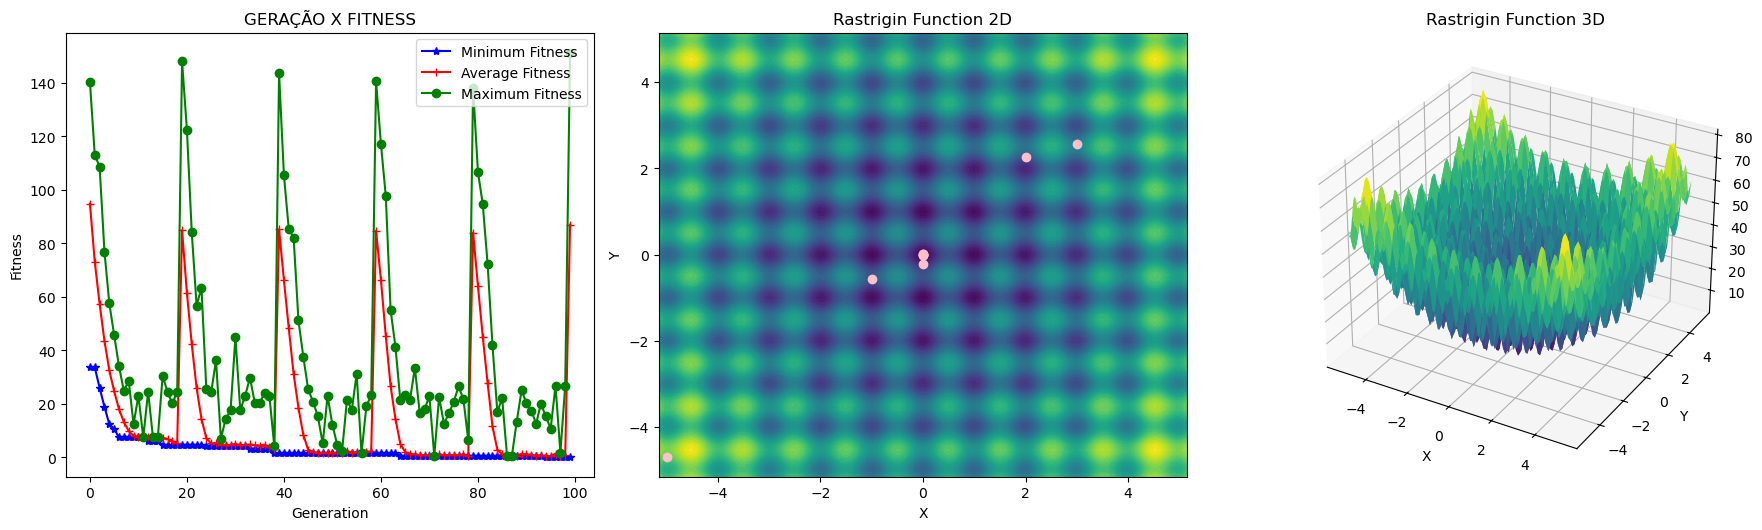

Soluções do problema

Best solution index =  94

Best solution variables =
 [3.7320219208815315, -1.0768120213256838, 0.03160166400438591, -0.5003759352670336, 4.343685973971199, 0.9320748029083905, -3.291299489035427, -4.720824808824782, 2.7803488287797675, 4.210371905416875]

Best solution fitness =  0.2513603574044936

Ótimo global da função Rastrigin =  92.5367389028908

Solução ótima global =  [ 3.97831907e+00 -9.92675862e-01  1.49040397e-03 -5.74029618e-05
  3.98020464e+00  9.94679949e-01 -2.98190624e+00 -4.97753231e+00
  2.98481871e+00  3.98194220e+00]

Porcentagem de proximidade da solução em relação ao ótimo global =  99.72836695956157 %

Distância da solução em relação ao ótimo global = <built-in function abs>


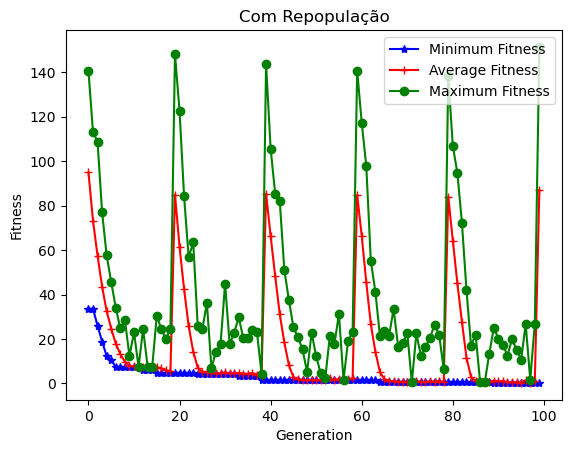

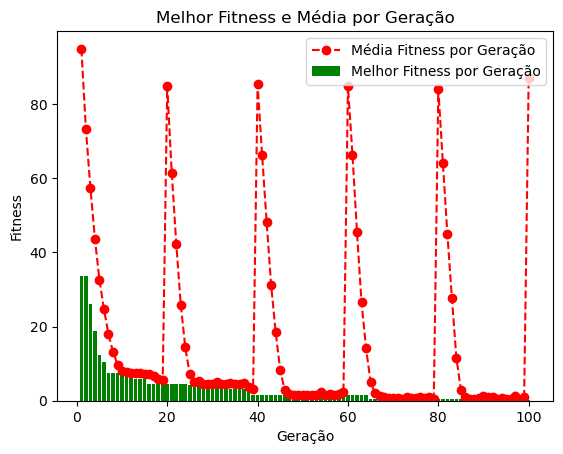

,Generation,Min Fitness,Average Fitness,Max Fitness,Std Fitness
0,0,33.584772,94.875885,140.484371,24.296775
1,1,33.584772,73.163602,113.080213,19.404635
2,2,25.950043,57.372543,108.666872,16.778182
3,3,18.836638,43.531060,76.892541,11.929127
4,4,12.338324,32.480446,57.542203,9.270008
...,...,...,...,...,...
95,95,0.251360,0.406593,10.725774,1.037183
96,96,0.251360,1.378729,26.662353,4.480112
97,97,0.251360,0.304918,1.739937,0.146175
98,98,0.251360,0.945575,26.753370,3.862845


Total execution time: 3.49 seconds


In [45]:
from src.models.AlgEvolution import AlgEvolution

def load_params(file_path):
    with open(file_path, "r") as file:
        params = json.load(file)
    return params

if __name__ == "__main__":
    tempo1 = time.time()

    # Setup
    params = load_params("/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/db/parameters.json")
    setup = Setup(params)
    alg = AlgoritimoEvolutivoRCE(setup)
    data_visual = DataExploration()
    # old_alg = AlgEvolution(setup)

    pop_with_repopulation, logbook_with_repopulation, best_variables = alg.run(
        RCE=True,
        fitness_function=rastrigin_decisionVariables,
        decision_variables=(X, y,data_hora,curva,vento),
    )

    print("\n\nEvolução concluída  - 100%")

    # Salvar resultados
    print("\n\nRESULTADOS OBTIDOS")
    data_visual.displayDataFrameInfo(alg.allIndividualValuesArray, "\n\nTodos Individuos Gerados")
    # data_visual.show_conjuntoElite(alg.pop_RCE)
    df = pd.DataFrame(alg.allIndividualValuesArray)
    display(df[df["Generations"]== 20])

    # Visualização dos resultados
    print("\n\nVISUALIZANDO OS RESULTADOS")
    data_visual.show_rastrigin_benchmark(logbook_with_repopulation,best_variables)
    data_visual.visualize(
        logbook_with_repopulation, pop_with_repopulation, repopulation=True
    )
    data_visual.statistics_per_generation_df(logbook_with_repopulation)

    tempo2 = time.time()
    print(f"Total execution time: {round(tempo2-tempo1,2)} seconds")